## Imports

In [1]:
from analasisAPI.subscriptionFinder import isDFweeklySchedule
from globals.column_names import BOA_DATE_COL
from analasisAPI.fileLoader import LoadFile 
from analasisAPI.queries import filterDataFrameByRegex
from analasisAPI.queries import filterDataFrameByDate
from analasisAPI.queries import filterDataFrameByAmount
from analasisAPI.queries import queryBankDataFrame
from analasisAPI.plotUtilities import plotDataFrameTimeSeriesCol
import datetime

from analasisAPI.bankUtils import combineBOAfiles

from classification.rule_based_classfier import classify_statement_from_rule_set
from classification.classification_report_utils import classification_pi_chart

import pandas as pd
import matplotlib.pyplot as plt


## Loading

In [2]:
# This should be the path to the file of your untouched BOA statement
filepath = "/home/jvarela/Documents/financial/stmt.csv"
# filepath = "sample.csv"

dataFrame = LoadFile(filepath)

regexDF = filterDataFrameByRegex(dataFrame,"uber")
#print(regexDF)

range1filter = filterDataFrameByDate(dataFrame,[datetime.datetime(2021,12,2),datetime.datetime(2022,12,22)])


## Classification

In [3]:
classified_df = classify_statement_from_rule_set(dataFrame)

classified_df.drop(columns=["Running Bal."], inplace=True, errors="ignore")

classified_df = classified_df.drop_duplicates()

classified_df.to_csv("training_data.csv",index=False)

## Analysis

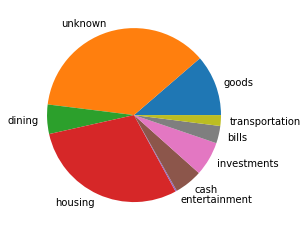

In [4]:
# Pi chart
classification_pi_chart(classified_df)


<BarContainer object of 5 artists>

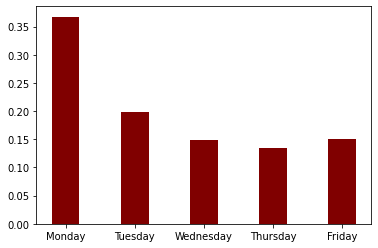

In [7]:
# Weekday binning
max_expense = 250.0 # max expense to analyze
expenses_only = classified_df[classified_df['Amount'] < 0] # get only expenses
small_expenses = filterDataFrameByAmount(expenses_only,[-max_expense,0.0])

# Note zero is monday
week_df = small_expenses.groupby(small_expenses['Date'].dt.dayofweek)['Amount'].sum()
day_of_week_names = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
days = []
spent_on_day = []
for day in week_df.keys():
    days.append(day_of_week_names[day])
    spent_on_day.append(-week_df[day])
total_spent = sum(spent_on_day)
spent_on_day = [val/total_spent for val in spent_on_day]
plt.bar(days, spent_on_day, color ='maroon',
        width = 0.4)
# I think I'm missing the weekend expenses as I always pay with my credit card on weekends?

Int64Index([0, 1, 2, 3, 4], dtype='int64', name='Date')